# Data exploration

Import the necessary modules.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

<br>

## 1. Import the cleaned data


Load the clean data files into pandas dataframes.

In [2]:
import_dir_path = os.path.join(os.getcwd(), 'clean_data')

order_items_df = pd.read_csv(os.path.join(import_dir_path, 'order_items.csv'), index_col=None)
orders_df = pd.read_csv(os.path.join(import_dir_path, 'orders.csv'), index_col=None)

<br>

Fix the default data types

In [3]:
order_items_df["Order ID"] = order_items_df["Order ID"].astype('int32')
order_items_df["Quantity Ordered"] = order_items_df["Quantity Ordered"].astype('int16')
orders_df["Order ID"] = orders_df["Order ID"].astype('int32')
orders_df["Order Date"] = pd.to_datetime(orders_df["Order Date"])
orders_df["Order Month"] = orders_df["Order Month"].astype('int8')
orders_df["Order Time"] = pd.to_datetime(orders_df["Order Time"]).dt.time

In [4]:
print("order_items dataframe:\n", order_items_df.dtypes)
print("\norders dataframe:\n", orders_df.dtypes)

order_items dataframe:
 Order ID              int32
Product              object
Quantity Ordered      int16
Price Each          float64
Total Price         float64
dtype: object

orders dataframe:
 Order ID                              int32
Order Date                   datetime64[ns]
Order Month                            int8
Order Time                           object
Purchase Address                     object
Purchase Address Street              object
Purchase Address City                object
Purchase Address State               object
Purchase Address Zip Code             int64
dtype: object


In [5]:
order_items_df.head(3)

,Order ID,Product,Quantity Ordered,Price Each,Total Price
0,176558,USB-C Charging Cable,2,11.95,23.90
1,176559,Bose SoundSport Headphones,1,99.99,99.99
2,176560,Google Phone,1,600.00,600.00


In [6]:
orders_df.head(3)

,Order ID,Order Date,Order Month,Order Time,Purchase Address,Purchase Address Street,Purchase Address City,Purchase Address State,Purchase Address Zip Code
0,176558,2019-04-19 08:46:00,4,08:46:00,"917 1st St, Dallas, TX 75001",917 1st St,Dallas,TX,75001
1,176559,2019-04-07 22:30:00,4,22:30:00,"682 Chestnut St, Boston, MA 02215",682 Chestnut St,Boston,MA,2215
2,176560,2019-04-12 14:38:00,4,14:38:00,"669 Spruce St, Los Angeles, CA 90001",669 Spruce St,Los Angeles,CA,90001


<br>

## 2. Data Exploration

First, show the time range of the available data.

In [7]:
print(   "Earliest record: {}".format( orders_df["Order Date"].dt.date.min() )   )
print(   "Latest record:   {}".format( orders_df["Order Date"].dt.date.max() )   )

Earliest record: 2019-01-01
Latest record:   2020-01-01


The data spans the whole year 2019, and a single day of 2020. Because of this disproportion, drop the data on year 2020.

In [8]:
orders_df = orders_df[orders_df["Order Date"].dt.year == 2019]
print(   "Latest record:   {}".format( orders_df["Order Date"].dt.date.max() )   )

Latest record:   2019-12-31


In [9]:
order_items_df = order_items_df[order_items_df["Order ID"].isin(orders_df["Order ID"])]

<br>

Next, put all the order placement times in 1-hour bins and show their distribution.

Text(0, 0.5, 'orders placed during the hour')

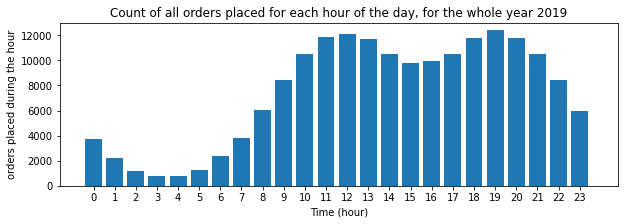

In [10]:
ax = orders_df["Order Date"].dt.hour.plot(kind='hist', figsize=(10, 3), bins=np.arange(25) - 0.4,
                                          xticks=np.arange(0, 24, 1), width=0.8)
ax.set_title("Count of all orders placed for each hour of the day, for the whole year 2019")
ax.set_xlabel("Time (hour)")
ax.set_ylabel("orders placed during the hour")

Next, show how many products were available, also show the quantity sold for the 5 most popular items.

In [11]:
print("Available products: {}".format( len(order_items_df["Product"].unique()) ))
order_items_df.groupby("Product")[["Quantity Ordered"]].sum().sort_values("Quantity Ordered", ascending=False).head(5)

Available products: 19


,Quantity Ordered
Product,
AAA Batteries (4-pack),30981
AA Batteries (4-pack),27615
USB-C Charging Cable,23927
Lightning Charging Cable,23163
Wired Headphones,20520


<br>

Lastly, show the total sales for the year

In [12]:
total_sales = order_items_df["Total Price"].sum()
total_mlns = round(total_sales // pow(10, 6))
total_ks   = round(total_sales % pow(10, 6)) // pow(10, 3)
total_rest = round(total_sales % 1000, 2)
print("Total sales: {}'{}'{} USD".format(total_mlns, total_ks, total_rest))

Total sales: 34'456'867.65 USD


<br>

## 3. Data analysis

<br> Show the total number of orders and their distribution over months.

Total number of orders: 178406


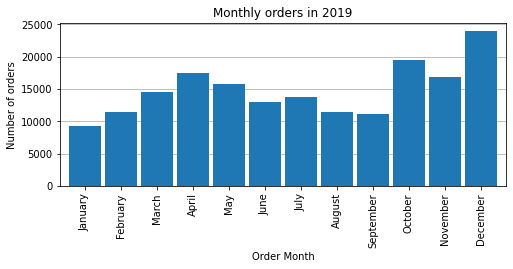

In [13]:
print("Total number of orders:", orders_df["Order ID"].count())

# create a dataframe based on orders dataframe, grouped by month, and count the orders.
orders_by_month = orders_df.groupby("Order Month", as_index=False)["Order ID"].count()
orders_by_month.rename(columns={"Order ID": "Count of Orders"}, inplace=True)

# create a column with a name of the month, for better axis readablity
orders_by_month["Order Month Name"] = pd.to_datetime(orders_by_month["Order Month"], format='%m').dt.month_name()

# plot the orders count against the month names
ax = orders_by_month.plot(kind='bar', figsize=(8, 3), x="Order Month Name", y="Count of Orders", width=0.9,
                          legend=None, zorder=10)
ax.set_title("Monthly orders in 2019")
ax.set_xlabel("Order Month")
ax.set_ylabel("Number of orders")
ax.grid('on', which='major', axis='y')

# orders_by_month

Monthly distribution of number of orders seems to be highly variant, reaching its peaks at April and December. Now show the hourly distribution.

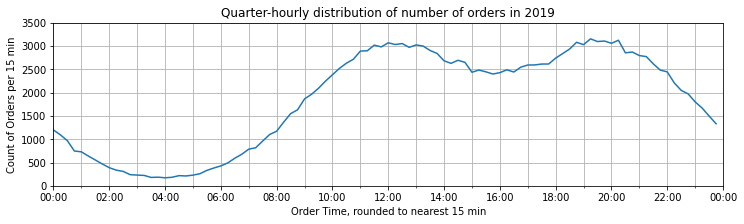

In [14]:
# temporarily create a field 'Rounded Time' from "Order Date" column
orders_df["Rounded Time"] = orders_df["Order Date"].dt.round(freq='15T').dt.time

# create a grouped version of orders dataframe
orders_by_hour = orders_df.groupby("Rounded Time", as_index=False)["Order ID"].count()
orders_by_hour.rename(columns={"Order ID": "Count of Orders"}, inplace=True)

# drop the temporary fiel 'Rounded Time' from the original dataframe
orders_df.drop(["Rounded Time"], axis=1, inplace=True)

# plot the hourly count of orders
ax = orders_by_hour.plot(figsize=(12, 3), kind='line', x="Rounded Time", y="Count of Orders", grid=True,
                         xticks=np.arange(0, 24 * 60 * 60 + 0.001, 2 * 60 * 60), legend=None,
                         xlim=(0, 24 * 60 * 60), ylim=(0, 3500))
ax.set_title('Quarter-hourly distribution of number of orders in 2019')
ax.set_xlabel("Order Time, rounded to nearest 15 min")
ax.set_ylabel("Count of Orders per 15 min")
ax.set_xticks(np.arange(0, 24 * 60 * 60 + 0.001, 1 * 60 * 60), minor=True)
ax.grid('on', which='minor', axis='x')

The highest order traffic can be observed at two periods of time, between 11:30 to 13:00 and between 18:45 and 20:15. During these hours, the traffic is almost identical, reaching above 3000 orders per 15 minutes.$\newline$
From the point of view of advertisment, 11:00 and 18:30, ought to be the most effective times for advertising, just before both peaks.

<br>

Now, shifting the focus on sales, show monthly sales across the year.

Month with highest sales: December, reaching 4.608 mln USD


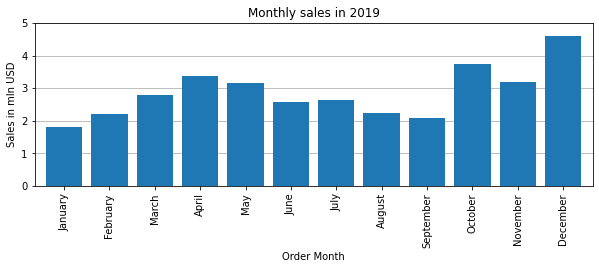

In [15]:
# Expand the orders dataframe by sales information from order_items
sales_df = order_items_df.groupby("Order ID", as_index=False)["Total Price"].sum()
sales_df.rename(columns={"Total Price": "Sales"}, inplace=True)
expanded_orders_df = pd.merge(orders_df, sales_df, on=["Order ID"])

# create a new dataframe based on expanded_orders dataframe, grouped by month
monthly_sales = expanded_orders_df.groupby("Order Month", as_index=False)["Sales"].sum()
monthly_sales["Sales mln USD"] = monthly_sales["Sales"] / pow(10, 6)

# create a column with a name of the month, for better axis readablity
monthly_sales["Order Month Name"] = pd.to_datetime(monthly_sales["Order Month"], format='%m').dt.month_name()

# plot the sales against order month
ax = monthly_sales.plot(kind='bar', figsize=(10, 3), x="Order Month Name", y="Sales mln USD", width=0.8,
                        ylim=(0, 5), legend=None, zorder=10)
ax.set_title("Monthly sales in 2019")
ax.set_xlabel("Order Month")
ax.set_ylabel("Sales in mln USD")
ax.grid('on', which='major', axis='y')

# print the information about the best month in terms of sales
best_month = monthly_sales[monthly_sales["Sales mln USD"] == monthly_sales["Sales mln USD"].max()]
print(   "Month with highest sales: {}, reaching {} mln USD".format(
                                                                    best_month["Order Month Name"].values[0],
                                                                    round(best_month["Sales mln USD"].values[0], 3) )   )

Sales distribution is similar to the distribution of orders. Similarily, two main peaks can be observed in April and December, where the highest peak of 4.608 mln USD occurred in December.

<br>

#### Location

Now, let's shift focus to geographic point of view. Show the states with the largest sales.

State with the highest yearly sales: California, reaching 13.7 mln USD, which was 39.8 % of total sales


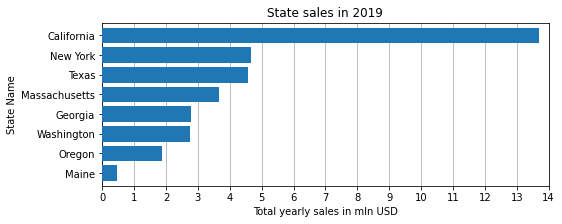

In [16]:
# use the expanded dataframe from earlier, group it by state and sort by sales
state_sales = expanded_orders_df.groupby("Purchase Address State", as_index=False)["Sales"].sum()
state_sales.sort_values("Sales", inplace=True, ascending=True)
state_sales["Sales mln USD"] = state_sales["Sales"] / pow(10, 6)
state_sales["Sales pct"] = 100 * state_sales["Sales"] / state_sales["Sales"].sum()

# create a new column with state names instead of acronyms
state_dict = {"CA": "California", "GA": "Georgia", "MA": "Massachusetts", "ME": "Maine",
              "NY": "New York", "OR": "Oregon", "TX": "Texas", "WA": "Washington"}
state_sales["State Name"] = state_sales["Purchase Address State"].replace(state_dict)

# plot sales against the state names
ax = state_sales.plot(kind='barh', figsize=(8, 3), legend=None, y="Sales mln USD", x="State Name",
                      width=0.8, zorder=10, xlim=(0, 14))
ax.set_title("State sales in 2019")
ax.set_xlabel("Total yearly sales in mln USD")
ax.set_xticks(np.arange(0, 14 + 0.1, 1))
ax.grid(axis='x')

# print the information about the best state in terms of sales
best_state = state_sales[state_sales["Sales mln USD"] == state_sales["Sales mln USD"].max()]
print("State with the highest yearly sales: {}, reaching {} mln USD, which was {} % of total sales".format(
    best_state["State Name"].values[0],
    round(best_state["Sales mln USD"].values[0], 3),
    round(best_state["Sales mln USD"].values[0] * 100 / state_sales["Sales mln USD"].sum(), 1)
))

# state_sales

Data indicates that California dominates the yearly sales, being responsible for 39.8 % (13.7 mln USD) of total sales in 2019. All states responsible for at least 10 % of total sales are:
- California, $\quad\;\;$ at 39.8 % (13.703 mln USD),
- New York, $\quad\;\;$ at 13.5 % (4.662 mln USD),
- Texas, $\quad\quad\;\;\;$ at 13.3 % (4.583 mln USD),
- Massachusetts, at 10.6 % (3.659 mln USD).

Now, show yearly sales for cities.

,Purchase Address City,Sales,Sales mln USD,Sales pct
1,Austin,1817544.35,1.817544,5.274839
6,Portland,2319178.95,2.319179,6.730673
8,Seattle,2744896.03,2.744896,7.966180
3,Dallas,2763659.01,2.763659,8.020633
0,Atlanta,2794199.07,2.794199,8.109266
2,Boston,3657300.76,3.657301,10.614142
5,New York City,4660526.52,4.660527,13.525683
4,Los Angeles,5447304.29,5.447304,15.809052
7,San Francisco,8252258.67,8.252259,23.949532


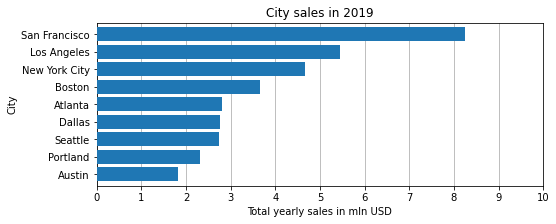

In [17]:
# use the expanded dataframe from earlier, group it by state and sort by sales
city_sales = expanded_orders_df.groupby("Purchase Address City", as_index=False)["Sales"].sum()
city_sales.sort_values("Sales", inplace=True, ascending=True)
city_sales["Sales mln USD"] = city_sales["Sales"] / pow(10, 6)
city_sales["Sales pct"] = 100 * city_sales["Sales"] / city_sales["Sales"].sum()

# plot sales against the city names
ax = city_sales.plot(kind='barh', figsize=(8, 3), legend=None, y="Sales mln USD", x="Purchase Address City",
                      width=0.8, zorder=10, xlim=(0, 10))
ax.set_title("City sales in 2019")
ax.set_xlabel("Total yearly sales in mln USD")
ax.set_ylabel("City")
ax.set_xticks(np.arange(0, 10 + 0.1, 1))
ax.grid(axis='x')

city_sales

The best city in terms of total sales turned out to be San Francisco, responsible for 24 % (8.255 mln USD) of total sales.

<br>

#### Products

Let's start by finding 10 most popular products.

In [18]:
# group the order_items dataframe by product name, in order to sum sales and quantities ordered
items_df = order_items_df.groupby("Product", as_index=False)[["Quantity Ordered", "Total Price"]].sum()
items_df.rename(columns={"Total Price": "Sales"}, inplace=True)
items_df["Sales mln USD"] = items_df["Sales"] / pow(10, 6)
items_df.sort_values("Quantity Ordered", ascending=False, inplace=True)
items_df.reset_index(drop=True, inplace=True)

# add information about the proudct unit prices
items_prices = order_items_df.loc[:, ["Product", "Price Each"]].drop_duplicates()
items_prices.reset_index(drop=True, inplace=True)
items_df = items_df.merge(items_prices, how='left', on="Product")
items_df[["Product", "Price Each", "Quantity Ordered", "Sales"]].set_index("Product").head(10)\
                                                                .style.format(precision=2, thousands=" ")

,Price Each,Quantity Ordered,Sales
Product,,,
AAA Batteries (4-pack),2.99,30 981,92 633.19
AA Batteries (4-pack),3.84,27 615,106 041.60
USB-C Charging Cable,11.95,23 927,285 927.65
Lightning Charging Cable,14.95,23 163,346 286.85
Wired Headphones,11.99,20 520,246 034.80
Apple Airpods Headphones,150.00,15 633,2 344 950.00
Bose SoundSport Headphones,99.99,13 427,1 342 565.73
27in FHD Monitor,149.99,7 538,1 130 624.62
iPhone,700.00,6 845,4 791 500.00


The most popular product turned out to be AAA battery pack (\~31 k orders), followed closely by AA battery pack (\~28 k orders). Both of those products are considerably cheaper than the rest of the products, and the whole table suggests strong correlation between product's price and it's popularity.

To delve deeper into the correlation between product's unit price and it's performance, show the Pearson correlation coefficients between chosen variables.

In [19]:
# use the grouped dataframe from the previous code cell
price_corr = items_df[["Price Each", "Quantity Ordered", "Sales"]].corr().loc[["Price Each"], :]
price_corr.style.set_caption("Pearson correlation coefficients for product's unit price:")

,Price Each,Quantity Ordered,Sales
Price Each,1.000000,-0.601277,0.865570


As expected, the correlation analysis suggests significant negative correlation between unit price and quantity of product sold. This means that expensive products are ordered less frequently. However, the strong correlation between unit price and sales means that those expensive products, even though ordered less frequently, are responsible for larger amount of total sales.
$\newline$
To better explore the correlation between unit price and sales, the linear regression model was plotted and described.

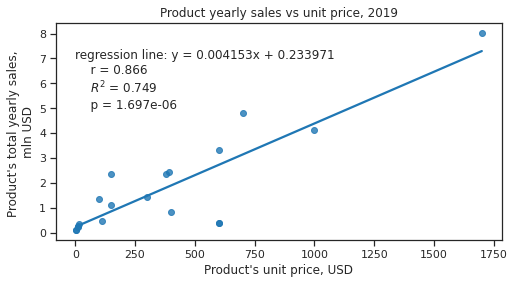

In [20]:
# get regression coefficients
a, b, r, p, std_dev = stats.linregress(items_df["Price Each"], items_df["Sales mln USD"])

# plot with regression line
sns.set_theme(rc = {'figure.figsize':(8, 4)}, style="ticks", palette=None)
ax = sns.regplot(data=items_df, x="Price Each", y="Sales mln USD", ci=None)
ax.annotate('regression line: y = {}x + {}\n    r = {}\n    $R^2$ = {}\n    p = {}'.format(
                round(a, 6), round(b, 6), round(r, 3), round(r*r, 3), round(p, 9)
            ), xy=(0, 5))
ax.set_title("Product yearly sales vs unit price, 2019")
ax.set_xlabel("Product's unit price, USD")
ax.set_ylabel("Product's total yearly sales, \nmln USD")
# sns.despine()     # get rid of boundries to the top and right of the plot
sns.reset_orig()  # this line prevents applying the current seaborn style to the next matplotlib plots

<br>

Now, let's shift the focus to the connection between the products. Show 10 most often combined products during purchase.

In [21]:
# create a list of possible combinations of product pairs, where the order is not important
# len = n! / ( k! * (n-k)! ), where n is a number of available products, and k = 2, being a number of items in a combination
unique_items = list(order_items_df["Product"].unique())
pairs = [(item1, item2)
            for i, item1 in enumerate(unique_items)
            for j, item2 in enumerate(unique_items)
            if i < j]

# check if the number of combinations is as expected
assert len(pairs) == math.factorial(len(unique_items)) // ( math.factorial(2) * math.factorial(len(unique_items) - 2) )

# create a dataframe for large orders (more than 1 item ordered), for now copy the main order_items dataframe and sort by ID
large_orders_df = order_items_df.loc[:, ["Order ID", "Product"]].sort_values("Order ID").reset_index(drop=True)

# add a column for number of products ordered in the order
large_orders_df["n of items ordered"] = large_orders_df.groupby('Order ID')["Order ID"].transform('count')

# filter out the orders with just one product ordered, then reset the index
large_orders_df = large_orders_df[large_orders_df["n of items ordered"] > 1].reset_index(drop=True)

# group the dataframe by Order ID, in order to obtain a combined string of each order's product names
products_in_orders_series = large_orders_df.groupby("Order ID")["Product"].apply(','.join)

# for every pair of products, count how many orders have this pair appeared in
pairs_data = []  # [ ["item1, item2", occurrances] ]
for item_list in pairs:
    # start with the series containing all product names in each order
    filtered_series = products_in_orders_series.iloc[:]
    
    # for each item in a current pair, filter out entries that do not contain it
    for item in item_list:
        filtered_series = filtered_series[filtered_series.str.contains(item, regex=False)]
    
    # update the pairs_data list
    pairs_data.append([', '.join(item_list), filtered_series.count()])

# make a dataframe from the pairs_data list, sort it, reset the index and show 10 most popular pairs
product_pairs_df = pd.DataFrame(pairs_data, columns=["Products in a pair", "Occurrances"])
product_pairs_df.sort_values("Occurrances", ascending=False, inplace=True)
product_pairs_df.reset_index(drop=True, inplace=True)
product_pairs_df.head(10)

,Products in a pair,Occurrances
0,"Lightning Charging Cable, iPhone",1010
1,"USB-C Charging Cable, Google Phone",997
2,"AA Batteries (4-pack), AAA Batteries (4-pack)",738
3,"Wired Headphones, iPhone",462
4,"Google Phone, Wired Headphones",422
5,"Apple Airpods Headphones, iPhone",372
6,"USB-C Charging Cable, Vareebadd Phone",368
7,"Bose SoundSport Headphones, Google Phone",228
8,"USB-C Charging Cable, Wired Headphones",203
9,"Lightning Charging Cable, AA Batteries (4-pack)",186


The most popular product pairing was a Lightning Charging Cable combined with iPhone (in 1011 orders), followed closely by a combination of USB-C Charging Cable and Google Phone (in 997 orders).